In [1]:
import Revise

In [2]:
import QuantumCollocation as QC
import NamedTrajectories as NT
import TrajectoryIndexingUtils as NTidx
import LinearAlgebra as LA
import SparseArrays as SA
import ForwardDiff as FD
import Plots
import Interpolations as IP
using LaTeXStrings
import JLD2

using FFTW:ifft, fft, fftshift, fftfreq

In [3]:
include("utils.jl")
include("system.jl")
include("constraints.jl")
include("objectives.jl")

QuadraticObjective (generic function with 3 methods)

In [ ]:
V = 10.
trunc = 11
# E_R [kHz] found in Weidner thesis
system = ShakenLatticeSystem1D(V, trunc; bloch_basis=true, bloch_transformation_trunc=2*trunc)
# middle index of statevector where p = 0
mid = system.params[:mid]
dim = system.params[:dim]
E_R = system.params[:E_R]
#E_R = 1/0.05
#print("time unit $(1/E_R) ms\nE_R = $E_R kHz")

In [ ]:
system.params[:bloch_energies]

In [ ]:
system.H_drives_real[1]

df = DF.DataFrame(CSV.File("./paper_data/split_fig6_coarse.csv"; header=0))

times = df[:,1] * E_R
dts = times[2:end] - times[1:end-1]
#push!(dts, dts[end])
#push!(dts, 0.)
phi = df[1:end-1,2]
#push!(phi, 0.)

duration = sum(dts) # in 1/E_R

T = length(dts)
dt_avg = duration / (T-1)
#dts = zeros(T) .+ dt
dt_bound = (minimum(dts), maximum(dts))
times = cumsum(dts) - dts

a_bound = fill(1., 2)
dda_bound = fill(50., 2)

a = vcat(cos.(phi)', sin.(phi)')

da = NT.derivative(a, dts)
dda = NT.derivative(da, dts)

In [ ]:
duration = 2pi * 0.5 # in units of 1/E_R

T = 401
dt = duration / (T-1)
dts = zeros(T) .+ dt
dt_bound = (dt, dt)
times = cumsum(dts) - dts
duration

In [ ]:
# phi_max = 3.0
# I_min = cos(phi_max)
# a_bound = [(I_min, 1.0), (-1.0, 1.0)]
a_bound = fill(1., 2)
dda_bound = fill(2000., 2)


#a = vcat(ones(T)', zeros(T)') 
#a = vcat(cos.(2pi * times/duration)', sin.(2pi * times/duration)')

#a = vcat(cos.(2. *sin.(11.5 *times))', sin.(2. *sin.(11.5 *times))') + vcat(cos.(2. *sin.(29.6 *times))', sin.(2. *sin.(29.6 *times))')
#a /= 2.

a = vcat(cos.(sin.(11.5 *times))', sin.(sin.(11.5 *times))')

da = NT.derivative(a, dts)
da[:, end] = da[:, end-1]
dda = NT.derivative(da, dts)
dda[:, end] = dda[:, end-1] = dda[:, end-2]

#####Victor solution
function get_pw_sin(sin_amps, sin_dts)
    N = length(sin_amps)
    sin_T = length(sin_dts)
    T = N*sin_T + 1
    sin_times = cumsum(sin_dts) - sin_dts
    sin_time = sin_times[end]
    dts = repeat(sin_dts, N)
    push!(dts, 0.)
    phi = zeros(T)
    for i=1:N
        phi[(i-1)*sin_T+1:i*sin_T] = (-1)^(i-1) * sin_amps[i] * sin.(pi*sin_times/sin_time)
    end
    a = zeros(2, T)
    a[1,:] = cos.(phi)
    a[2,:] = sin.(phi)
    return a, dts, cumsum(dts) - dts
end

sin_amps = [3.73064, 3.63246, 1.86532, 1.17809, 1.17809, 1.17809, 0.58904 ]
#sin_amps = [0.39269908, 0.68722339, 0.68722339, 0.49087385, 0.49087385, 0.78539816, 0.78539816]
#append!(sin_amps, sin_amps[end:-1:1])
freq = 11.5 # angular in units of \omega_R
sin_time = 2pi * 1/freq / 2
sin_T = 25
sin_dts = fill(sin_time / sin_T, sin_T)
a, dts, times = get_pw_sin(sin_amps, sin_dts)
T = length(times)

a_bound = fill(1., 2)
dt_bound = (dts[1], dts[1])

da = NT.derivative(a, dts)
da[:, end] = da[:, end-1]
dda = NT.derivative(da, dts)
dda[:, end] = dda[:, end-1] = dda[:, end-2]

In [ ]:
Z = NT.load_traj("./interferometer/split_bloch78.jld2")

In [ ]:
Z = NT.load_traj("./interferometer/mirror_victor2_opt.jld2")

In [ ]:
a, dts = Z.a, vec(Z.dts)

# a = a[:,1:end-50]
# dts = dts[1:end-50]

times = cumsum(dts) - dts
T = length(times)

In [ ]:
dts

In [ ]:
dt_fix = 0.0109273'

In [ ]:
dt = dts[1]
T_new = Int(floor(times[end] / dt_fix + 1))
#T_new = 401
#dt_fix = times[end] / (T_new - 1)

In [ ]:
T_new

In [ ]:
a_itp = IP.interpolate(a, (IP.NoInterp(), IP.BSpline(IP.Cubic(IP.Free(IP.OnCell())))))
times_itp = IP.interpolate(times, IP.BSpline(IP.Linear()));

In [ ]:
a = hcat([[a_itp(j, 1+x*dt_fix/dt) for j=1:2] for x=0:T_new-1]...)
times = [times_itp(1+x*dt_fix/dt) for x=0:T_new-1]
dts = vcat(times[2:end] - times[1:end-1], 0)

a = hcat([[a_itp(j, 1+x/2) for j=1:2] for x=0:2*(T-1)]...)
times = [times_itp(1+x/2) for x=0:2*(T-1)]
dts = vcat(times[2:end] - times[1:end-1], 0)

In [ ]:
times

In [ ]:
duration = times[end]
T = length(times)
dt = duration/(T-1)
dt_bound = (dt, dt)
T

In [ ]:
#a_bound = fill(1., 2)
# phi_max = 3.0
# I_min = cos(phi_max)
# a_bound = [(I_min, 1.0), (-1.0, 1.0)]
a_bound = fill(1.0, 2)
dda_bound = fill(2000., 2)

da = NT.derivative(a, dts)
da[:, end] = da[:, end-1]
dda = NT.derivative(da, dts)
dda[:, end] = dda[:, end-1] = dda[:, end-2]

In [ ]:
times

In [ ]:
Plots.plot(times, a')

In [ ]:
Plots.plot(times, da')

In [ ]:
Plots.plot(times, dda')

In [ ]:
phi = angle.(a[1,:] + 1im*a[2,:])
phi_mod_clean!(phi)

In [ ]:
phi = atan.(a[2,:], a[1,:])
phi_mod_clean!(phi)

In [ ]:
Plots.plot(times, phi)

psi0 = zeros(system.params[:dim])
psi0[mid] = 0.
psi0[mid-1] = sqrt(0.5)
psi0[mid+1] = sqrt(0.5)
normalize!(psi0)

In [ ]:
#psi0 = get_bloch_state(system; lvl=0)
psi0 = QC.cavity_state(3, dim)

In [ ]:
#Plots.bar(-p_max:p_max, abs2.(psi0))
Plots.bar(0:dim-1, abs2.(psi0))

In [ ]:
psi0_iso = QC.ket_to_iso(psi0)

In [ ]:
psi_iso = QC.rollout(psi0_iso, a, dts, system; integrator=exp)

psi_iso += rand(size(psi_iso)...)

In [ ]:
psi = hcat([QC.iso_to_ket(psi_iso[:,t]) for t=1:T]...)
pops = abs2.(psi)

In [ ]:
#Plots.plot(times, pops[:,:]', labels=(-p_max:1:p_max)', legend=:outertopright)#, xlim=(0.0, 2.0))
Plots.plot(times, pops[:,:]', labels=(0:dim-1)', legend=:outertopright)#, xlim=(0.0, 2.0))

bloch_states = hcat([get_bloch_state(system; lvl=i) for i=0:dim-1]...)

psi

blochs = bloch_states' * psi
bloch_pops = abs2.(blochs)

Plots.plot(times, bloch_pops[:,:]', labels=(0:8)', legend=:outertopright)#, xlim=(0.0, 2.0))

pops[:, end]

In [ ]:
comps = (
    psi_iso = psi_iso,
    a = a,
    da = da,
    dda = dda,
    dts = dts
)
initial = (
    psi_iso = psi0_iso,
    a = [1.; 0.],
    #da = zeros(2)
)
final = (;
    a = [1.; 0.],
    #da = zeros(2)
)
goal = (;)
bounds = (
    a = a_bound,
    dda = dda_bound,
    dts = dt_bound
)

Z_guess = nothing
GC.gc()
Z_guess = NT.NamedTrajectory(
    comps;
    controls=(:dda),
    timestep=:dts,
    bounds=bounds,
    initial=initial,
    final=final,
    goal=goal
)

import JLD2

JLD2.save("./interferometer/mirror_victor2_opt2.jld2", Z_guess)

Z_guess = NT.copy(Z_save)

NT.update_bounds!(Z_guess, :dda, [-5000. -5000.; 5000. 5000.])

In [ ]:
#state_goal = get_bloch_state(system; lvl=7)
state_goal = QC.cavity_state(3, dim)

In [ ]:
pops_goal = abs2.(state_goal)

In [ ]:
dim = system.params[:dim]

In [ ]:
R = collect(LA.I(dim))
R[8,8] = R[9,9] = 0.
R = QC.QuantumSystems.iso(R)

In [ ]:
# J = NameComponentPathObjective(
#     :psi_iso,
#     1:dim,
#     [1:T...],
#     [time -> pop for pop in pops_goal],
#     [x -> abs2.(x) for _=1:dim],
#     collect(1:T)' .* fill(1., dim, T);
#     is_iso=true
# )

# J = NameComponentPathObjective(
#     :psi_iso,
#     1:2*dim,
#     [1:T...],
#     [time -> s for s in QC.ket_to_iso(state_goal)],
#     [x -> x for _=1:2*dim],
#     collect(1:T)' .* fill(1., 2*dim, T);
#     is_iso=false
# )

# J += NameComponentQuadraticRegularizer(:a, [2], Z_guess, ones(1)*1e-1; is_iso=false)

# J = NameComponentObjective(:psi_iso, [mid-1], steer_to_pops([0.5]), 1.0; is_iso=true)
# J += NameComponentObjective(:psi_iso, [mid+1], steer_to_pops([0.5]), 1.0; is_iso=true)
# J += NameComponentObjective(:psi_iso, [mid], steer_to_pops([0.0]), 1.0; is_iso=true)

#J += NameComponentQuadraticRegularizer(:psi_iso, [mid-2, mid+2], Z_guess, ones(2)*1e-3; is_iso=true)
# J += NameComponentQuadraticRegularizer(:psi_iso, [mid-1, mid+1], Z_guess, ones(2)*1e-3; is_iso=true)

#J = NameComponentObjective(:psi_iso, [1:dim...], [1:T...], x -> 1 - abs2.(x' * state_goal), ([1:T...] ./ T) .* 100.; is_iso=true)
J = QC.QuantumObjective(name=:psi_iso, goals=QC.ket_to_iso(state_goal), loss=:InfidelityLoss, Q=100.0)
#J += QC.QuadraticRegularizer(:dts, Z_guess, 0.01)
#J += NameComponentQuadraticRegularizer(:a, [2], Z_guess, [0.001])

# J = QuadraticObjective(:psi_iso, R, 100.0)
# J += NameComponentObjective(:psi_iso, [8, 9], [T], x -> real(x[1]'*x[2])^2, [100.0]; is_iso=true)
J += QC.QuadraticRegularizer(:dda, Z_guess, 1e-8/T)

In [ ]:
J.L(Z_guess.datavec, Z_guess)

In [ ]:
integrators = nothing
GC.gc()
integrators = [
    QC.QuantumStatePadeIntegrator(
        system,
        :psi_iso,
        :a,
        :dts;
        order=4
    ),
    QC.DerivativeIntegrator(
        :a,
        :da,
        :dts,
        Z_guess
    ),
    QC.DerivativeIntegrator(
        :da,
        :dda,
        :dts,
        Z_guess
    )
]

In [ ]:
constraints = [
    OmegaAbsConstraint(1.0, Z_guess),
    #PhiSincConvolutionConstraint(:a, :dts, Z_guess, 80.),
    #PhiFunctionBoundConstraint(phase_bound, Z_guess),
    #TimeSymmetricControlConstraint(:a, Z_guess)
    #custom_bounds_constraint(:a, Z_guess, Int[], a_bound)
]

In [ ]:
# Ipopt options
options = QC.Options(
    max_iter=200,
)

In [ ]:
# defining quantum control problem
prob = nothing
GC.gc()
prob = QC.QuantumControlProblem(
    system, 
    Z_guess, 
    J, 
    integrators;
    constraints=constraints,
    options=options,
)

In [ ]:
QC.solve!(prob)

In [ ]:
Z = nothing
GC.gc()
Z = prob.trajectory

In [ ]:
Z.psi_iso

In [ ]:
psi_iso_rollout = QC.rollout(psi0_iso, Z.a, Z.dts, system; integrator=exp)
psi = hcat([QC.iso_to_ket(psi_iso_rollout[:,t]) for t=1:T]...)
pops = abs2.(psi)

psi = hcat([QC.iso_to_ket(Z.psi_iso[:,t]) for t=1:T]...)
pops = hcat([abs2.(QC.iso_to_ket(Z.psi_iso[:,t])) for t=1:T]...)

In [ ]:
psi[:,end]

In [ ]:
state_goal

In [ ]:
1 - Z.psi_iso[:,end]' * R * Z.psi_iso[:,end]

In [ ]:
x = QC.iso_to_ket(Z.psi_iso[:,end])

In [ ]:
x / exp(1im*angle(x[8]))

In [ ]:
pops_goal

In [ ]:
times = cumsum(Z.dts[1,:]) - Z.dts[1,:]

In [ ]:
#p = Plots.plot(times, pops[:,:]', labels=(-p_max:1:p_max)', legend=:outertopright, size=(500, 300))
p = Plots.plot(times, pops[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    #ylabel=L"population of momentum state $|p\rangle$"
    ylabel="Bloch state population"
)
Plots.title!(p, "Splitting shaking sequence")

In [ ]:
Plots.plot(times, pops[end,:])

blochs = bloch_states' * psi
bloch_pops = abs2.(blochs)

p = Plots.plot(times, bloch_pops[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\nu_R]$"
)
Plots.yaxis!(p, 
    ylabel=L"population of Bloch state $|B\rangle$"
)
Plots.title!(p, "Splitting shaking sequence")

In [ ]:
Plots.plot(times, Z.a')

In [ ]:
Plots.plot(times, Z.da')

In [ ]:
Plots.plot(times, Z.dda')

In [ ]:
phi = angle.(Z.a[1,:] + 1im * Z.a[2,:]);
phi_mod_clean!(phi)

In [ ]:
times_f1 = times[div(2*T,3):end]
sin_f1 = pi/2*sin.(29.6*(times_f1 .- 0.27)) .- pi/2
times_f2 = times[1:div(2*T,3)]
sin_f2 = pi*sin.(11.5*(times_f2));

In [ ]:
p = Plots.plot(times, phi, linecolor=:blue, label=L"\varphi(t)", size=(500, 300))
# Plots.plot!(p, times_f1, sin_f1, linecolor=:red, alpha=0.2, label=L"\omega=29.6")
# Plots.plot!(p, times_f2, sin_f2, linecolor=:green, alpha=0.2, label=L"\omega=11.5")
# Plots.plot!(p, times, phase_bound.(times), linecolor=:grey, label="bound")
# Plots.plot!(p, times, -phase_bound.(times), linecolor=:grey, label="bound")
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="shaking amplitude"
)
Plots.title!(p, "Splitting shaking sequence")

In [ ]:
Plots.plot(times[150:250], Z.a[:,150:250]')

In [ ]:
Plots.plot(times[150:250], Z.a[1,150:250].^2 + Z.a[2,150:250].^2)

In [ ]:
Plots.plot(times[150:250], phi[150:250])

In [ ]:
maximum(phi)

In [ ]:
Z_guess = Z
Z_save = deepcopy(Z)

In [ ]:
import JLD2

JLD2.save("interferometer/split_bloch78.jld2", Z)

In [ ]:
function fourier_time_freq(data_time, times, freqs)
    dts = times[2:end] - times[1:end-1]
    push!(dts, dts[end])
    ft_mat = exp.(2im*pi*freqs*times')
    data_freq = (dts' .* ft_mat) * data_time / sqrt.(2pi)
    return data_freq
end

In [ ]:
slice = 1:T #div(2*T,3):T

In [ ]:
freqs = collect(0:0.1:80)
phi_ft = fourier_time_freq(phi[slice], times[slice], freqs/2pi);

In [ ]:
p = Plots.plot(freqs, abs2.(phi_ft), size=(500, 300), label=nothing)
Plots.xaxis!(p, 
    xlabel=L"$\omega$ $[\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="Fourier amplitude"
)
Plots.title!(p, "Shaking protocol spectrum")

# mirror

In [ ]:
V = 10.
trunc = 11
# E_R [kHz] found in Weidner thesis
system = ShakenLatticeSystem1D(V, trunc; bloch_basis=true, bloch_transformation_trunc=2*trunc)
# middle index of statevector where p = 0
mid = system.params[:mid]
dim = system.params[:dim]
E_R = system.params[:E_R]
#E_R = 1/0.05
#print("time unit $(1/E_R) ms\nE_R = $E_R kHz")

In [ ]:
for i=0:15
    println("$i\t$(system.params[:bloch_energies][i+1])")
end

In [ ]:
Plots.bar(real.(system.params[:bloch_states][:,[7,8].+1]))

In [ ]:
system.H_drives_real[1]

In [ ]:
duration = 2pi * 0.5 # in units of 1/E_R

T = 401
dt = duration / (T-1)
dts = zeros(T) .+ dt
dt_bound = (dt, dt)
times = cumsum(dts) - dts
duration

In [ ]:
a_bound = fill(1., 2)
dda_bound = fill(2000., 2)


a = vcat(ones(T)', zeros(T)') 
#a = vcat(cos.(2pi * times/duration)', sin.(2pi * times/duration)')

# a = vcat(cos.(2. *sin.(11.5 *times))', sin.(2. *sin.(11.5 *times))') + vcat(cos.(2. *sin.(29.6 *times))', sin.(2. *sin.(29.6 *times))')
# a /= 2.

#a = 1. * vcat(cos.(sin.(29.6 *times))', sin.(sin.(29.6 *times))')

da = NT.derivative(a, dts)
da[:, end] = da[:, end-1]
dda = NT.derivative(da, dts)
dda[:, end] = dda[:, end-1] = dda[:, end-2]

In [ ]:
Z1 = NT.load_traj("./interferometer/bloch_7_to_3.jld2")
Z2 = NT.load_traj("./interferometer/mirror_victor2.jld2")

In [ ]:
Z1.dts, Z2.dts

In [ ]:
a, dts = get_interferometer(Z1, Z2, [])
times = cumsum(dts) - dts
T = length(times)

In [ ]:
Z = NT.load_traj("./interferometer/mirror_bloch7_bitshorter.jld2")

In [ ]:
Z = NT.load_traj("./interferometer/mirror_victor2.jld2")

In [ ]:
a, dts = Z.a, vec(Z.dts)
times = cumsum(dts) - dts
duration = times[end]
T = length(times)

In [ ]:
T_new = 600
dt_new = duration[end]/(T_new-1)
dts_new = fill(dt_new, T_new);

In [ ]:
a = interpolate_controls(a, dts, dts_new)
times = cumsum(dts_new) - dts_new;

In [ ]:
a = a[:,1:500]
times = times[1:500]

In [ ]:
duration = times[end]
T = length(times)
dt = duration/(T-1)
dts = fill(dt, T)
dt_bound = (dt, dt)
T

In [ ]:
a_bound = fill(1., 2)
dda_bound = fill(2000., 2)

da = NT.derivative(a, dts)
da[:, end] = da[:, end-1]
dda = NT.derivative(da, dts)
dda[:, end] = dda[:, end-1] = dda[:, end-2]

In [ ]:
times

In [ ]:
Plots.plot(times, a')

In [ ]:
Plots.plot(times, da')

In [ ]:
Plots.plot(times, dda')

In [ ]:
phi = angle.(a[1,:] + 1im*a[2,:])
phi_mod_clean!(phi)

In [ ]:
p = Plots.plot(times, phi, linecolor=:blue, label=L"\varphi(t)", size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="shaking amplitude"
)
Plots.title!(p, L"Mirror $|7\rangle$ (guess)")

psi0 = zeros(system.params[:dim])
psi0[mid] = 0.
psi0[mid-1] = sqrt(0.5)
psi0[mid+1] = sqrt(0.5)
normalize!(psi0)

#####Victor solution
function get_pw_sin(sin_amps, sin_dts)
    N = length(sin_amps)
    sin_T = length(sin_dts)
    T = N*sin_T + 1
    sin_times = cumsum(sin_dts) - sin_dts
    sin_time = sin_times[end]
    dts = repeat(sin_dts, N)
    push!(dts, 0.)
    phi = zeros(T)
    for i=1:N
        phi[(i-1)*sin_T+1:i*sin_T] = (-1)^(i-1) * sin_amps[i] * sin.(pi*sin_times/sin_time)
    end
    a = zeros(2, T)
    a[1,:] = cos.(phi)
    a[2,:] = sin.(phi)
    return a, dts, cumsum(dts) - dts
end

sin_amps = [0.3926, 0.6872, 0.6872, 0.4908, 0.4908, 0.7853, 0.7853]
append!(sin_amps, sin_amps[end:-1:1]) 

freq = 11.5
sin_time = 2pi * 1/freq / 2
sin_T = 20
sin_dts = fill(sin_time / sin_T, sin_T)
a, dts, times = get_pw_sin(sin_amps, sin_dts)
T = length(times)

a_bound = fill(1., 2)
dda_bound = fill(10000., 2)
dt_bound = (dts[1], dts[1])

da = NT.derivative(a, dts)
da[:, end] = da[:, end-1]
dda = NT.derivative(da, dts)
dda[:, end] = dda[:, end-1] = dda[:, end-2]

In [ ]:
#psi0 = get_bloch_state(system; lvl=3)
psi0 = QC.cavity_state(3, dim)
v0 = psi0 + QC.cavity_state(4, dim)
normalize!(v0)
w0 = psi0 - QC.cavity_state(4, dim)
normalize!(w0)

In [ ]:
system.params[:bloch_energies]

In [ ]:
Plots.bar(0:dim-1, hcat(real.(psi0), real.(v0), real.(w0)))

In [ ]:
psi0_iso = QC.ket_to_iso(psi0)
v0_iso = QC.ket_to_iso(v0)
w0_iso = QC.ket_to_iso(w0)

In [ ]:
psi_iso = QC.rollout(psi0_iso, a, dts, system; integrator=exp)
v_iso = QC.rollout(v0_iso, a, dts, system; integrator=exp)

In [ ]:
psi = hcat([QC.iso_to_ket(psi_iso[:,t]) for t=1:T]...)
psi_pops = abs2.(psi)
v = hcat([QC.iso_to_ket(v_iso[:,t]) for t=1:T]...)
v_pops = abs2.(v)

In [ ]:
p = Plots.plot(times, psi_pops[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    #ylabel=L"population of momentum state $|p\rangle$"
    ylabel="Bloch state population"
)
Plots.title!(p, L"Mirror $|3\rangle \rightarrow |3\rangle$ (guess)")

In [ ]:
p = Plots.plot(times, v_pops[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    #ylabel=L"population of momentum state $|p\rangle$"
    ylabel="Bloch state population"
)
Plots.title!(p, L"Mirror $|3\rangle + |4\rangle \rightarrow |3\rangle - |4\rangle$")

In [ ]:
comps = (
    psi_iso = psi_iso,
    v_iso = v_iso,
    a = a,
    da = da,
    dda = dda,
    dts = dts
)
initial = (
    psi_iso = psi0_iso,
    v_iso = v0_iso,
    a = [1.; 0.],
    #da = zeros(2)
)
final = (;
    a = [1.; 0.],
    #da = zeros(2)
)
goal = (;)
bounds = (
    a = a_bound,
    dda = dda_bound,
    dts = dt_bound
)

Z_guess = nothing
GC.gc()
Z_guess = NT.NamedTrajectory(
    comps;
    controls=(:dda),
    timestep=:dts,
    bounds=bounds,
    initial=initial,
    final=final,
    goal=goal
)

In [ ]:
dim = system.params[:dim]

#J = NameComponentObjective(:psi_iso, [1:dim...], [1:T...], x -> 1 - abs2.(x' * state_goal), ([1:T...] ./ T) .* 100.; is_iso=true)
J = QC.QuantumObjective(name=:psi_iso, goals=psi0_iso, loss=:InfidelityLoss, Q=100.0)
J += QC.QuantumObjective(name=:v_iso, goals=w0_iso, loss=:InfidelityLoss, Q=100.0)
#J += QC.QuadraticRegularizer(:dts, Z_guess, 0.01)
#J += NameComponentQuadraticRegularizer(:a, [2], Z_guess, [0.001])
J += QC.QuadraticRegularizer(:dda, Z_guess, 1e-8/T)

In [ ]:
J.L(Z_guess.datavec, Z_guess)

In [ ]:
integrators = nothing
GC.gc()
integrators = [
    QC.QuantumStatePadeIntegrator(
        system,
        :psi_iso,
        :a,
        :dts;
        order=4
    ),
    QC.QuantumStatePadeIntegrator(
        system,
        :v_iso,
        :a,
        :dts;
        order=4
    ),
    QC.DerivativeIntegrator(
        :a,
        :da,
        :dts,
        Z_guess
    ),
    QC.DerivativeIntegrator(
        :da,
        :dda,
        :dts,
        Z_guess
    )
]

In [ ]:
constraints = [
    OmegaAbsConstraint(1.0, Z_guess),
    #LinearSincConvolutionConstraint3(:a, :dts, Z_guess, 50.)
    #PhiFunctionBoundConstraint(phase_bound, Z_guess),
    #TimeSymmetricControlConstraint(:a, Z_guess)
]

In [ ]:
# Ipopt options
options = QC.Options(
    max_iter=100,
)

In [ ]:
# defining quantum control problem
prob = nothing
GC.gc()
prob = QC.QuantumControlProblem(
    system, 
    Z_guess, 
    J, 
    integrators;
    constraints=constraints,
    options=options,
)

In [ ]:
QC.solve!(prob)

In [ ]:
Z = nothing
GC.gc()
Z = prob.trajectory

In [ ]:
psi_iso_rollout = QC.rollout(psi0_iso, Z.a, Z.dts, system; integrator=exp)
psi = hcat([QC.iso_to_ket(psi_iso_rollout[:,t]) for t=1:T]...)
pops = abs2.(psi)

v_iso_rollout = QC.rollout(v0_iso, Z.a, Z.dts, system; integrator=exp)
v = hcat([QC.iso_to_ket(v_iso_rollout[:,t]) for t=1:T]...)
v_pops = abs2.(v)

psi = hcat([QC.iso_to_ket(Z.psi_iso[:,t]) for t=1:T]...)
pops = hcat([abs2.(QC.iso_to_ket(Z.psi_iso[:,t])) for t=1:T]...)

In [ ]:
psi[:,end]

In [ ]:
abs2.(psi[:,end]' * psi0)

In [ ]:
abs2.(v[:,end]' * w0)

In [ ]:
times = cumsum(Z.dts[1,:]) - Z.dts[1,:]

In [ ]:
p = Plots.plot(times, pops[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="Bloch state population"
)
Plots.title!(p, L"Mirror $|3\rangle \rightarrow |3\rangle$")

In [ ]:
p = Plots.plot(times, v_pops[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="Bloch state population"
)
Plots.title!(p, L"Mirror $|3\rangle + |4\rangle \rightarrow |3\rangle - |4\rangle$")

In [ ]:
Plots.plot(times, Z.a')

In [ ]:
Plots.plot(times, Z.da')

In [ ]:
Plots.plot(times, Z.dda')

In [ ]:
phi = angle.(Z.a[1,:] + 1im * Z.a[2,:]);
phi_mod_clean!(phi)

In [ ]:
p = Plots.plot(times, phi, linecolor=:blue, label=L"\varphi(t)", size=(500, 300))
# Plots.plot!(p, times, phase_bound.(times), linecolor=:grey, label="bound")
# Plots.plot!(p, times, -phase_bound.(times), linecolor=:grey, label="bound")
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="shaking amplitude"
)
Plots.title!(p, L"Mirror $|7\rangle$")

In [ ]:
pops[:,end]

In [ ]:
Plots.plot(times, acos.(Z.a[1,:]))

In [ ]:
Z_guess = Z
Z_save = deepcopy(Z)

In [ ]:
import JLD2

In [ ]:
JLD2.save("interferometer/mirror_victor2_opt.jld2", Z)

In [ ]:
function fourier_time_freq(data_time, times, freqs)
    dts = times[2:end] - times[1:end-1]
    push!(dts, dts[end])
    ft_mat = exp.(2im*pi*freqs*times')
    data_freq = (dts' .* ft_mat) * data_time / sqrt.(2pi)
    return data_freq
end

In [ ]:
freqs = collect(0:0.1:60)
phi_ft = fourier_time_freq(Z.a[2,:], times, freqs/(2pi));
#phi_ft = fourier_time_freq(phi, times, freqs/(2pi));

In [ ]:
Plots.plot(freqs, abs2.(phi_ft))#, ylims=(0.0, 0.01))

In [ ]:
sinc_con.kernel

In [ ]:
a2 = (sinc_con.kernel * Z.a[1:2,1:end-1]')'

In [ ]:
phi2 = angle.(a2[1,:] + 1im*a2[2,:])

In [ ]:
phi2 = sinc_con.kernel * phi[1:T-1]

In [ ]:
Plots.plot(a2')

In [ ]:
Plots.plot(abs2.(a2'))

In [ ]:
freqs = collect(0:0.1:50)
#phi_ft = fourier_time_freq(Z.a[1,:], times, freqs/(2pi));
phi_ft = fourier_time_freq(phi2, times[1:end-1], freqs/(2pi));

In [ ]:
Plots.plot(freqs, abs2.(phi_ft))#, ylims=(0.0, 0.01))

# interferometer

In [4]:
Z_split = NT.load_traj("interferometer/split_victor_opt2.jld2")
Z_mirror = NT.load_traj("interferometer/mirror_victor2_opt.jld2")

NamedTrajectories.StructNamedTrajectory.NamedTrajectory{Float64}([0.0 -6.74855911342975e-12 … -0.0013475110125116415 -0.00014029408499702744; 0.0 7.543499631655139e-12 … -0.00019101865258386647 -0.00018160743097781347; … ; -1106.4640281182446 -1147.1386528878531 … -0.046016781365011174 5.982053206278144e-14; 0.007853979999999995 0.007853979999999995 … 0.007853979999999995 0.007853979999999995], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  -0.0004792971420200619, 0.0003122772169715187, -0.001598354193206295, 1.0, 0.0, 3.046752804557673, 27.68595236951833, 0.026256128995310907, 5.982053206278144e-14, 0.007853979999999995], 487, :dts, 51, (psi_iso = 22, v_iso = 22, a = 2, da = 2, dda = 2, dts = 1, states = 49, controls = 2), (a = ([-1.0, -1.0], [1.0, 1.0]), dda = ([-2000.0, -2000.0], [2000.0, 2000.0]), dts = ([0.007853979999999995], [0.007853979999999995])), (psi_iso = [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], v_iso =

In [84]:
time_flight = 2pi * 1.0
dt_flight = Z_split.dts[1]
T_flight = Int(div(time_flight,dt_flight)) + 1

575

In [85]:
a, dts = get_interferometer(Z_split, Z_mirror, fill(dt_flight, T_flight))
#a, dts = get_interferometer(Z_split, Z_mirror, [])
times = cumsum(dts) - dts
T = length(times)

1987

In [86]:
V = 10.
trunc = 11
# E_R [kHz] found in Weidner thesis
system = ShakenLatticeSystem1D(V, trunc; bloch_basis=true, bloch_transformation_trunc=2*trunc)
# middle index of statevector where p = 0
mid = system.params[:mid]
dim = system.params[:dim]
E_R = system.params[:E_R]
#E_R = 1/0.05
#print("time unit $(1/E_R) ms\nE_R = $E_R kHz")

8.939026187912745

In [87]:
psi0 = QC.cavity_state(0, dim)
psi0_iso = QC.ket_to_iso(psi0)

22-element Vector{Float64}:
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [88]:
lbls = reshape(0:dim-1, 1, dim)

1×11 reshape(::UnitRange{Int64}, 1, 11) with eltype Int64:
 0  1  2  3  4  5  6  7  8  9  10

In [89]:
psi_iso = QC.rollout(psi0_iso, a, dts, system);

In [90]:
psi = hcat([QC.iso_to_ket(psi_iso[:,t]) for t=1:T]...)
pops = abs2.(psi)

11×1987 Matrix{Float64}:
 1.0  1.0          0.999825     0.99867      …  0.998011     0.998011
 0.0  2.11238e-35  0.000163028  0.00120792      1.69956e-5   1.69956e-5
 0.0  2.35344e-33  2.7227e-6    4.95718e-5      2.17132e-5   2.17132e-5
 0.0  1.31227e-34  8.84031e-6   6.52109e-5      0.000166306  0.000166306
 0.0  3.30039e-34  3.50061e-7   6.47273e-6      0.000288212  0.000288212
 0.0  3.15033e-36  3.80256e-8   2.87122e-7   …  0.000164973  0.000164973
 0.0  4.58916e-37  1.90127e-9   4.85288e-8      0.000158819  0.000158819
 0.0  2.54408e-42  2.57898e-11  2.65558e-10     0.000885103  0.000885103
 0.0  5.49948e-39  3.74481e-12  1.63499e-10     2.52422e-5   2.52422e-5
 0.0  5.58392e-42  4.67898e-15  1.09478e-13     1.86344e-5   1.86344e-5
 0.0  7.68814e-43  4.07793e-15  1.99758e-13  …  0.000243085  0.000243085

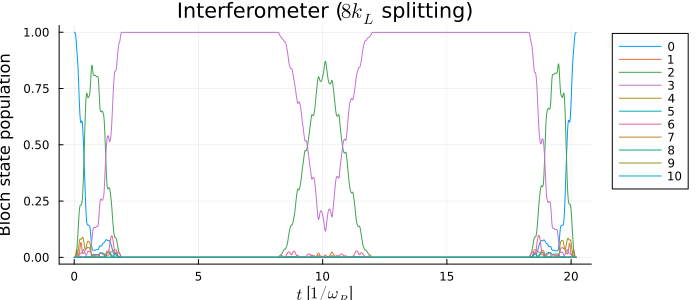

In [91]:
p = Plots.plot(times, pops[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(700, 300))
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="Bloch state population"
)
Plots.title!(p, L"Interferometer ($8 k_L$ splitting)")

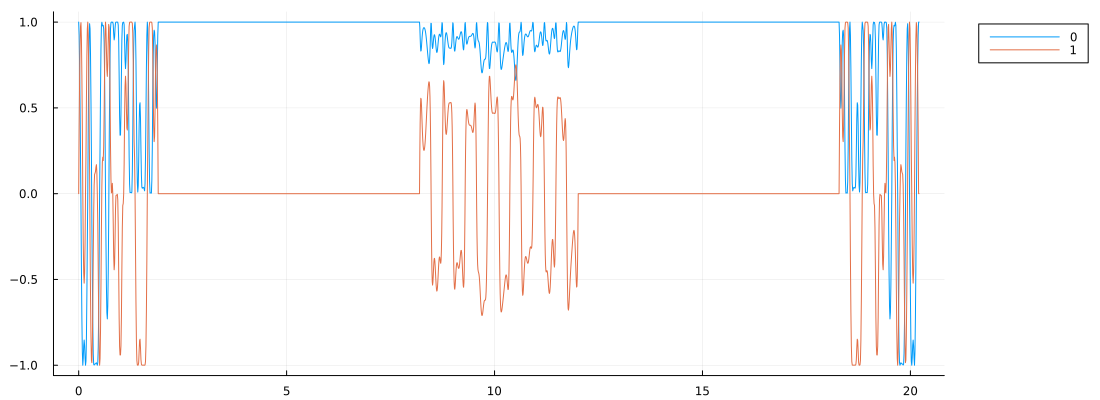

In [92]:
Plots.plot(times, a', size=(1100, 400), label=lbls, legend=:outertopright)

In [93]:
phi = angle.(a[1,:] + im*a[2,:])
phi_mod_clean!(phi);

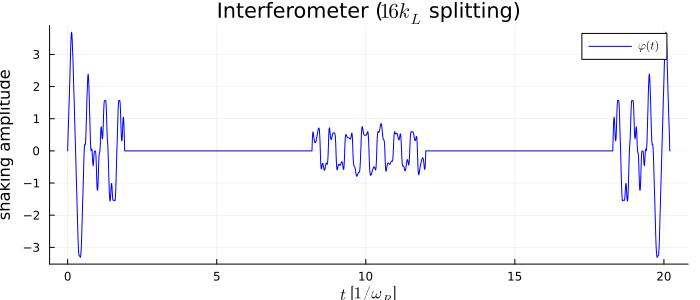

In [94]:
p = Plots.plot(times, phi, linecolor=:blue, label=L"\varphi(t)", size=(700, 300))
# Plots.plot!(p, times, phase_bound.(times), linecolor=:grey, label="bound")
# Plots.plot!(p, times, -phase_bound.(times), linecolor=:grey, label="bound")
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\omega_R]$"
)
Plots.yaxis!(p, 
    ylabel="shaking amplitude"
)
Plots.title!(p, L"Interferometer ($16k_L$ splitting)")

In [96]:
system_acc = ShakenLatticeSystem1D(V, trunc; bloch_basis=true, bloch_transformation_trunc=2*trunc, include_acc_derivative=true)
a_acc = vcat(a, times')

3×1987 Matrix{Float64}:
 1.0  0.92278    0.747452   0.523177   …   0.92278    1.0     1.0
 0.0  0.385328   0.664316   0.852224       0.385328   0.0     0.0
 0.0  0.0109273  0.0218546  0.0327818     20.1861    20.197  20.208

In [97]:
psi0_acc = vcat(psi0, zeros(length(psi0)))
psi0_acc_iso = QC.ket_to_iso(psi0_acc)

44-element Vector{Float64}:
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [98]:
psi_acc_iso = QC.rollout(psi0_acc_iso, a_acc, dts, system_acc)

44×1987 Matrix{Float64}:
 1.0   0.999723      0.998933     …    -0.460618     -0.481345
 0.0   3.36336e-20  -0.0127668         -0.00228407   -0.00241335
 0.0  -9.17021e-19  -4.13865e-5         0.00386076    0.00369356
 0.0   8.77989e-19  -0.00296762        -0.0115927    -0.0104171
 0.0  -1.3956e-18    2.83146e-5         0.0123162     0.010062
 0.0   3.27204e-19   0.000190945  …    -0.0114522    -0.0128076
 0.0  -1.24884e-19   1.33189e-5         0.00509318    0.000273417
 0.0   5.2901e-22   -4.57377e-6         0.0155972    -0.00438146
 0.0   2.45957e-20   1.24929e-6         0.00301344   -0.000283331
 0.0  -1.20226e-21  -4.69696e-8         0.00252026    0.00427226
 ⋮                                ⋱     ⋮           
 0.0   0.0           5.99787e-6   …   -47.8498      -38.6089
 0.0   0.0           2.88157e-5       294.438       307.741
 0.0   0.0          -5.0616e-6        318.915       295.19
 0.0   0.0          -9.05931e-7        51.9701       62.3274
 0.0   0.0          -6.86756e-7    

In [99]:
# psi_acc = hcat([QC.iso_to_ket(psi_acc_iso[:,t])[1:dim] for t=1:T]...)
# pops_acc = hcat([abs2.(QC.iso_to_ket(psi_acc_iso[:,t]))[1:dim] for t=1:T]...)

psi_acc = hcat([QC.iso_to_ket(psi_acc_iso[:,t]) for t=1:T]...)
pops_acc = abs2.(psi_acc)

22×1987 Matrix{Float64}:
 1.0  1.0          0.999825     …      0.998011         0.998011
 0.0  2.11238e-35  0.000163028         1.69956e-5       1.69956e-5
 0.0  2.35344e-33  2.7227e-6           2.17132e-5       2.17132e-5
 0.0  1.31227e-34  8.84031e-6          0.000166306      0.000166306
 0.0  3.30039e-34  3.50061e-7          0.000288212      0.000288212
 0.0  3.15033e-36  3.80256e-8   …      0.000164973      0.000164973
 0.0  4.58916e-37  1.90127e-9          0.000158819      0.000158819
 0.0  2.54408e-42  2.57898e-11         0.000885103      0.000885103
 0.0  5.49948e-39  3.74481e-12         2.52422e-5       2.52422e-5
 0.0  5.58392e-42  4.67898e-15         1.86344e-5       1.86344e-5
 ⋮                              ⋱      ⋮            
 0.0  0.0          3.59749e-11     24544.9          24545.0
 0.0  0.0          8.36904e-10     97027.2          97031.8
 0.0  0.0          2.57281e-11  …      1.12943e5        1.1292e5
 0.0  0.0          9.04853e-13      4095.58          4096.88
 0.

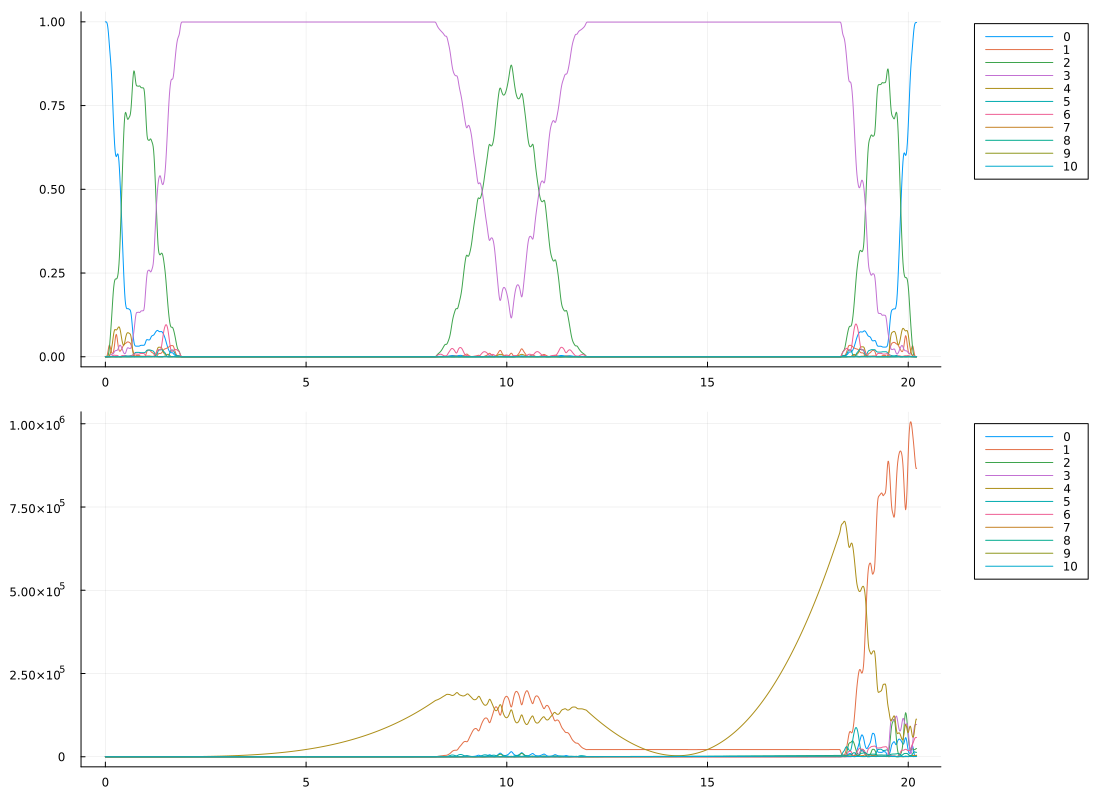

In [100]:
p1 = Plots.plot(times, pops_acc[1:dim,:]', label=lbls, legend=:outertopright)
p2 = Plots.plot(times, pops_acc[dim+1:end,:]', label=lbls, legend=:outertopright)
Plots.plot(p1, p2, size=(1100, 800), layout=Plots.@layout [a; b])

In [101]:
bloch_states = system.params[:bloch_states]
d = size(bloch_states,1)
bloch_states = bloch_states[(1:dim) .+ div(d,4) .+ 1, 1:dim]

11×11 Matrix{ComplexF64}:
  3.1013e-6-0.0im    1.16331e-5-0.0im  …     0.627236+0.0im
 0.00012667-0.0im   0.000448867-0.0im      -0.0436382-0.0im
 0.00334874-0.0im     0.0108523-0.0im      0.00170576+0.0im
  0.0509792-0.0im      0.140664-0.0im      -5.0787e-5-0.0im
   0.366823-0.0im      0.692889+0.0im      1.32407e-6+0.0im
   0.851858+0.0im   9.84655e-16-0.0im  …  -7.38961e-8-0.0im
   0.366823-0.0im     -0.692889-0.0im      1.63271e-6+0.0im
  0.0509792-0.0im     -0.140664-0.0im     -6.26428e-5-0.0im
 0.00334874-0.0im    -0.0108523-0.0im      0.00210396+0.0im
 0.00012667-0.0im  -0.000448867-0.0im      -0.0538252-0.0im
  3.1013e-6-0.0im   -1.16331e-5-0.0im  …     0.773659+0.0im

In [102]:
B = blockdiagonal(bloch_states, bloch_states)

22×22 SparseArrays.SparseMatrixCSC{ComplexF64, Int64} with 242 stored entries:
⎡⣿⣿⣿⣿⣿⡇⠀⠀⠀⠀⠀⎤
⎢⣿⣿⣿⣿⣿⡇⠀⠀⠀⠀⠀⎥
⎢⠿⠿⠿⠿⠿⢇⣀⣀⣀⣀⣀⎥
⎢⠀⠀⠀⠀⠀⢸⣿⣿⣿⣿⣿⎥
⎢⠀⠀⠀⠀⠀⢸⣿⣿⣿⣿⣿⎥
⎣⠀⠀⠀⠀⠀⠘⠛⠛⠛⠛⠛⎦

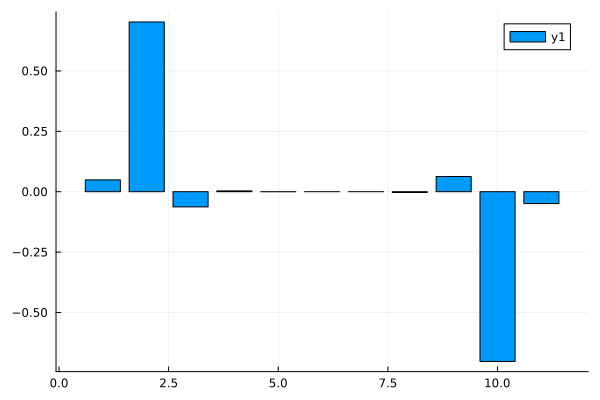

In [103]:
Plots.bar(real.(bloch_states[:,8]))

In [104]:
bloch_states * psi_acc[1:dim,:]

11×1987 Matrix{ComplexF64}:
  3.1013e-6+0.0im   3.10044e-6+7.29585e-8im  …    0.0115056-0.00720211im
 0.00012667+0.0im  0.000126635+2.97992e-6im      -0.0033357-0.0244646im
 0.00334874+0.0im   0.00334781+7.87795e-5im      0.00775123-0.00357382im
  0.0509792+0.0im    0.0509651+0.00119929im       -0.026844+0.0413356im
   0.366823+0.0im     0.366722+0.00862956im       -0.180349+0.32136im
   0.851858+0.0im     0.851622+0.02004im     …    -0.407647+0.743613im
   0.366823+0.0im     0.366722+0.00862956im       -0.180117+0.328113im
  0.0509792+0.0im    0.0509651+0.00119929im     -0.00956566+0.0321883im
 0.00334874+0.0im   0.00334781+7.87795e-5im     -0.00883815-0.00988727im
 0.00012667+0.0im  0.000126635+2.97992e-6im      0.00158958+0.0167172im
  3.1013e-6+0.0im   3.10044e-6+7.29585e-8im  …   0.00785006-0.00463083im

In [105]:
p_acc = B * psi_acc
p_pops_acc = abs2.(p_acc)

22×1987 Matrix{Float64}:
 9.61806e-12  9.61806e-12  3.77374e-12  …      0.000166876      0.000184249
 1.60453e-8   1.60453e-8   8.82483e-9          0.00063789       0.000609645
 1.12141e-5   1.12141e-5   7.99688e-6          7.87125e-5       7.28538e-5
 0.00259888   0.00259888   0.00222418          0.00235088       0.00242923
 0.134559     0.134559     0.128411            0.13568          0.135798
 0.725661     0.725661     0.725563     …      0.719354         0.719136
 0.134559     0.134559     0.140776            0.139881         0.1401
 0.00259888   0.00259888   0.00300185          0.00132479       0.00112759
 1.12141e-5   1.12141e-5   1.51186e-5          0.000151817      0.000175871
 1.60453e-8   1.60453e-8   2.65799e-8          0.000281805      0.000281993
 ⋮                                      ⋱      ⋮            
 0.0          0.0          4.2717e-11      23254.3          24294.9
 0.0          0.0          5.20413e-9          1.00504e5        1.0156e5
 0.0          0.0          

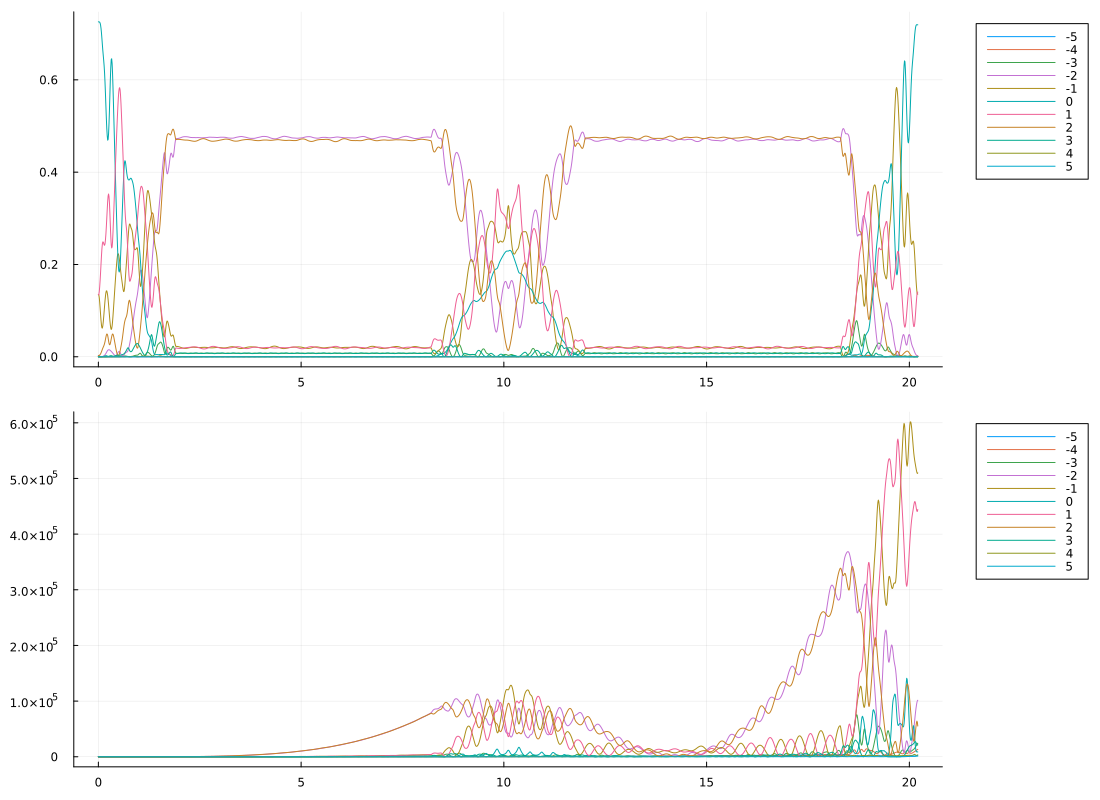

In [106]:
p1 = Plots.plot(times, p_pops_acc[1:dim,:]', label=(-div(dim,2):div(dim,2))', legend=:outertopright)
p2 = Plots.plot(times, p_pops_acc[dim+1:end,:]', label=(-div(dim,2):div(dim,2))', legend=:outertopright)
Plots.plot(p1, p2, size=(1100, 800), layout=Plots.@layout [a; b])

In [107]:
p_pops_acc[dim+1:end,end]

11-element Vector{Float64}:
   2603.5263502166504
  13335.318352073144
  24294.93923952075
 101559.8412291242
 509930.4743837098
   8566.462579065863
 444220.8790215611
  55252.04444842573
  21316.7621782216
   3482.4254570598937
   1234.2917138997389

In [109]:
MZFI = (8pi*(times[end]/2)^2)^2

6.583380911023029e6

In [123]:
time_flight

6.283185307179586

In [126]:
MZFI = (8pi*(time_flight)^2)^2

984462.5342211114

In [133]:
function Fisher(psi, dpsi)
    eps = 0.0
    P = abs2.(psi)
    D = 2*imag.(conj.(psi) .* dpsi)
    F = (1 ./ (P .+ eps))' * D.^2
    return F / MZFI
end 


Fisher (generic function with 1 method)

In [134]:
#fisher = psi_dpsi -> Fisher(QC.iso_to_ket(psi_dpsi)[1:dim], QC.iso_to_ket(psi_dpsi)[dim+1:2*dim])
fisher = psi_dpsi -> Fisher(psi_dpsi[1:dim], psi_dpsi[dim+1:2*dim])

#398 (generic function with 1 method)

In [135]:
fisher_info = [fisher(p_acc[:,t]) for t=1:T]

1987-element Vector{Float64}:
 0.0
 0.0
 6.628297390807073e-13
 5.9640284942353964e-12
 2.3920351264758825e-11
 6.696917965372235e-11
 1.5279401799056515e-10
 3.053775568113934e-10
 5.559651327017657e-10
 9.44278189102377e-10
 ⋮
 0.9982109513385736
 0.7904080390164556
 0.6875546556472966
 0.6758585036178321
 0.7424271729744361
 0.894209576694753
 1.1340068712867946
 1.4613405113661597
 1.8296352781101628

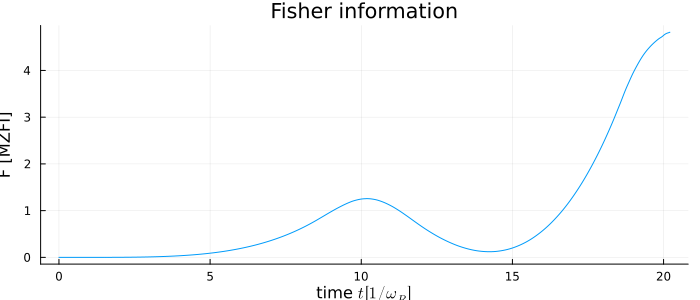

In [132]:
# abs
p = Plots.plot(times, fisher_info, size=(700, 300), label=nothing)
Plots.xlabel!(p, L"time $t \, [1/\omega_R]$")
Plots.ylabel!(p, "F [MZFI]")
Plots.title!(p, "Fisher information")

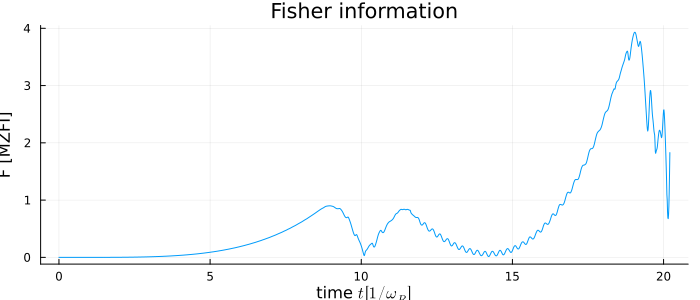

In [136]:
# imag
p = Plots.plot(times, fisher_info, size=(700, 300), label=nothing)
Plots.xlabel!(p, L"time $t \, [1/\omega_R]$")
Plots.ylabel!(p, "F [MZFI]")
Plots.title!(p, "Fisher information")

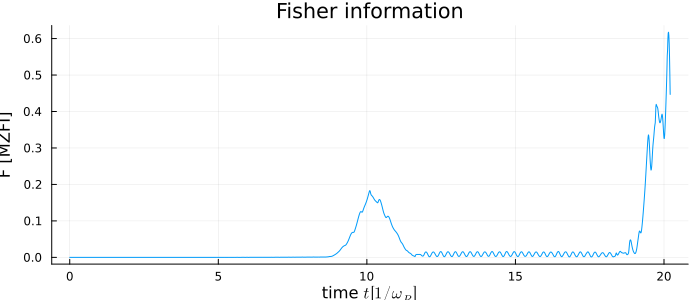

In [122]:
# real
p = Plots.plot(times, fisher_info, size=(700, 300), label=nothing)
Plots.xlabel!(p, L"time $t \, [1/\omega_R]$")
Plots.ylabel!(p, "F [MZFI]")
Plots.title!(p, "Fisher information")

In [ ]:
function fisher_for_flight(dts_flight):
    a, dts = get_interferometer(Z_split, Z_mirror, fill(dt_flight, T_flight))
    times = cumsum(dts) - dts
    T = length(times)
    system_acc = ShakenLatticeSystem1D(V, p_max; include_acc_derivative=true)
    a_acc = vcat(a, times')
    psi0_acc = vcat(psi0, zeros(length(psi0)))
    psi0_acc_iso = QC.ket_to_iso(psi0_acc)
    psi_acc_iso = QC.rollout(psi0_acc_iso, a_acc, dts, system_acc)

In [ ]:
dim = system.params[:dim]
# J = NameComponentPathObjective(
#     :psi_iso,
#     1:dim,
#     [1:T...],
#     [time -> pop for pop in pops_goal],
#     [x -> abs2.(x) for _=1:dim],
#     collect(1:T)' .* fill(1., dim, T);
#     is_iso=true
# )

# J = NameComponentPathObjective(
#     :psi_iso,
#     1:2*dim,
#     [1:T...],
#     [time -> s for s in QC.ket_to_iso(state_goal)],
#     [x -> x for _=1:2*dim],
#     collect(1:T)' .* fill(1., 2*dim, T);
#     is_iso=false
# )

# J += NameComponentQuadraticRegularizer(:a, [2], Z_guess, ones(1)*1e-1; is_iso=false)

# J = NameComponentObjective(:psi_iso, [mid-1], steer_to_pops([0.5]), 1.0; is_iso=true)
# J += NameComponentObjective(:psi_iso, [mid+1], steer_to_pops([0.5]), 1.0; is_iso=true)
# J += NameComponentObjective(:psi_iso, [mid], steer_to_pops([0.0]), 1.0; is_iso=true)

#J += NameComponentQuadraticRegularizer(:psi_iso, [mid-2, mid+2], Z_guess, ones(2)*1e-3; is_iso=true)
# J += NameComponentQuadraticRegularizer(:psi_iso, [mid-1, mid+1], Z_guess, ones(2)*1e-3; is_iso=true)

#J = NameComponentObjective(:psi_iso, [1:dim...], [1:T...], x -> 1 - abs2.(x' * state_goal), ([1:T...] ./ T) .* 100.; is_iso=true)
J = QC.QuantumObjective(name=:psi_iso, goals=QC.ket_to_iso(state_goal), loss=:InfidelityLoss, Q=100.0)
J += QC.QuadraticRegularizer(:dts, Z_guess, 0.01)
#J += NameComponentQuadraticRegularizer(:a, [2], Z_guess, [0.001])
J += QC.QuadraticRegularizer(:dda, Z_guess, 1e-7/T)

In [ ]:
dim = 15
mid = div(dim + 1, 2)

In [ ]:
ps = collect(-mid+1:mid-1)

In [ ]:
psi0 = zeros(dim)
psi0[mid] = 0.8
psi0[mid-1] = -0.6
psi0[mid+1] = -0.6

In [ ]:
s = 3
psi0 = exp.(-ps.^2/s^2)
psi0 ./ LA.norm(psi0)

In [ ]:
Plots.plot(ps, psi0)

In [ ]:
psi0_ft = ifft(psi0)

In [ ]:
x_vals = fftshift(fftfreq(dim))

In [ ]:
abs2.(psi0_ft)

In [ ]:
x_vals

In [ ]:
psi0_ft

In [ ]:
fig = Plots.plot(x_vals, abs2.(fftshift(psi0_ft)), ylimit=(0,0.001))

In [ ]:
FFTW.fftshift(FFTW.fftfreq(10))

In [ ]:
function p_to_x(psi_p, xs)
    dim = length(psi_p)
    p_max = div(dim - 1, 2)
    ps = collect(-p_max:p_max) 
    ft_mat = exp.(1im*xs*ps')
    return ft_mat * psi_p / sqrt.(2pi)
end

In [ ]:
function x_to_p(psi_x, xs, p_max)
    ps = collect(-p_max:p_max) 
    ft_mat = exp.(-1im*ps*xs')
    return ft_mat * psi_x .* (xs[2] - xs[1]) / sqrt.(2pi)
end

In [ ]:
xs = LinRange(-10, 10, 1000)

In [ ]:
psi0_ft2 = p_to_x(psi0, xs)

In [ ]:
Plots.plot(xs, hcat(abs2.(psi0_ft2), cos.(xs)))

In [ ]:
sx = 1
psi_x = exp.(-(xs .- pi).^2 / sx^2)
psi_x ./= LA.norm(psi_x) * sqrt.(xs[2]-xs[1])

In [ ]:
sum(abs2.(psi_x)) * (xs[2]-xs[1])

In [ ]:
Plots.plot(xs, hcat(abs2.(psi_x), -cos.(xs)))


In [ ]:
psi_p = x_to_p(psi_x, xs, 20)

In [ ]:
Plots.plot(-20:20, abs2.(psi_p))

In [ ]:
psi_p_ft = fft(psi_x)

In [ ]:
Plots.plot(fftshift(fftfreq(1000))*500/2/pi, fftshift(abs2.(psi_p_ft)), xlimit=(-10, 10))